# Qiskit: quantum circuit simulation

In [1]:
#| default_exp platform.simulation.qcircuit_sim

In [83]:
#| export
from generator.imports import *
from generator.config_loader import *
from typing import List

from QuICT.core import *
from QuICT.core.gate import *
from QuICT.simulation.density_matrix import DensityMatrixSimulator

from qiskit import transpile

## Circuit

In [70]:
#| export
def get_number_of_gate_params(gate_cls):
    # return gate_cls.__init__.__code__.co_argcount - len(gate_cls.__init__.__defaults__) - 1 
    return gate_cls.params

In [95]:
#| export
def gate_pool_to_gate_classes(gate_pool: list[BasicGate]): 
    """Creates a vocabulary from a gate pool."""
    classes = {}
    
    for i,cls in enumerate(gate_pool):
        num_of_paramters = get_number_of_gate_params(cls)
        name = cls(*[0]*num_of_paramters).type.name
        classes[name] = (i+1)
        
    return classes

In [23]:
#| export
def instruction_name_to_gate(name: str) -> BasicGate:
    gate = gate_builder(gate_type=GateType[name])
    
    return gate

In [34]:
#| export
def trace_density(rho: np.ndarray, qindex: List[int]) -> np.ndarray:
    """ Output partial trace of the density matrix on th given qubits

    Args:
        rho (ndarray): Input density matrix.
        qindex (List[int]): A list of integers indicating the qubits to be traced.

    Returns: the partially traced density matrix.
    """
    if len(qindex) == 0:
        return rho

    size_rho = int(np.ceil(np.log2(max(rho.shape))))

    # group into successive qubit blocks
    sorted_q = sorted(qindex)
    if sorted_q[-1] > size_rho:
        raise ValueError("Qubit index out of range.")
    tr_q_info = []

    i = 0
    while i < len(qindex):
        step = 0
        while i + step < len(qindex):
            if sorted_q[i] + step == sorted_q[i + step]:
                step += 1
            else:
                break
        tr_q_info.append([sorted_q[i], sorted_q[i + step - 1]])
        i = i + step

    tr_q_info = np.array(tr_q_info, dtype=int)

    # consecutive partial trace
    reduced_rho = rho
    while tr_q_info.size > 0:
        start, end = tr_q_info[0, :].tolist()
        axis1, axis2 = 0, 1
        ein_reshape_dim = []
        post_reshape_dim = 1

        cur_size = int(np.ceil(np.log2(max(reduced_rho.shape))))

        pre_dim_exp = start
        post_dim_exp = cur_size - end - 1

        if pre_dim_exp > 0:
            axis1 += 1
            axis2 += 2

            ein_reshape_dim.append(1 << pre_dim_exp)
            post_reshape_dim = post_reshape_dim * (1 << pre_dim_exp)

        ein_reshape_dim.append(1 << (end - start + 1))

        if post_dim_exp > 0:
            axis2 += 1

            ein_reshape_dim.append(1 << post_dim_exp)
            post_reshape_dim = post_reshape_dim * (1 << post_dim_exp)

        reduced_rho = reduced_rho.reshape(ein_reshape_dim * 2)
        reduced_rho = np.trace(reduced_rho, axis1=axis1, axis2=axis2)
        reduced_rho = reduced_rho.reshape((post_reshape_dim, post_reshape_dim))

        # update q_info indices
        tr_q_info = tr_q_info - (end - start + 1)
        # update for next partial trace qubit block
        tr_q_info = tr_q_info[1:]

    return reduced_rho

In [46]:
#| export
def schmidt_rank_vector(densityMatrix: np.array):   
    """Return the SRV of a `DensityMatrix`."""
    systems_cnt = int(np.log2(densityMatrix.shape[0]))  
    total_trace = set(range(systems_cnt))    
    rank_vector = []
    
    for i in range(systems_cnt): 
        trace = list(total_trace - {i})
        red_densityMatrix = trace_density(densityMatrix, trace)        
        # r = np.count_nonzero(np.linalg.eigvals(red_densityMatrix) > 1e-14) # was slower during testing   
        r = np.linalg.matrix_rank(red_densityMatrix, hermitian=True).item()       
        rank_vector.append(r)
    
    return rank_vector

In [76]:
#| export
def rnd_circuit(num_of_qubits, num_of_gates, gate_pool: list[BasicGate], rng):
    """Create a random circuit."""
    qc = Circuit(num_of_qubits)    
    gate_indices = rng.choice(len(gate_pool), num_of_gates)
    
    for gate_index in gate_indices:
        gate_class = gate_pool[gate_index]
        
        num_of_paramters = get_number_of_gate_params(gate_class)
        params           = rng.uniform(low=0, high=2*np.pi, size=num_of_paramters) if num_of_paramters > 0 else [] # random between 0 and 2pi
        
        gate = gate_class(*params)      
        act_qubits = rng.choice(num_of_qubits, gate.targets + gate.controls, replace=False) # order: (*act_qubits)=(*control_qubits, *target_qubits)   
        gate | qc([*act_qubits])
    
    return qc

In [93]:
#| export
def optimize_circuit(qc: Circuit, gate_pool: list[BasicGate], optimization_level=2):
    """Use qiskit.compiler.transpile to optimize a circuit.
       This might cause some problem???
    """
    basis_gates = gate_pool_to_gate_classes(gate_pool).keys()
    
    while optimization_level > 0:
        try:
            qc_opt = transpile(qc, optimization_level=optimization_level, basis_gates=basis_gates) #target=target
            print(type(qc_opt))
            return qc_opt
        except Exception as er: pass
  
        optimization_level -= 1

    return qc

In [ ]:
gs = [H, CX, CRy]
qc = rnd_circuit(num_of_qubits=3, num_of_gates=8, gate_pool=gs, rng=np.random.default_rng())
simulator = DensityMatrixSimulator(
    device="CPU",
    precision="double"
)
result = simulator.run(qc)
svr = schmidt_rank_vector(result)
display(f"Rand: svr={svr}", qc.draw('command'))

In [ ]:
qc = optimize_circuit(qc, gs)
svr = schmidt_rank_vector(result)
display(f"Opti: svr={svr}", qc.draw('command'))

In [113]:
#| export
def plot_svr_stat(num_of_qubits, min_gates, max_gates, gs, samples, sort=False, opt=True, rng=np.random.default_rng()):    
    svr_list = list()
    for i in range(samples):
        qc = rnd_circuit(num_of_qubits, rng.integers(min_gates, max_gates+1), gs, rng) 
        if opt: qc = optimize_circuit(qc, gs)
        simulator = DensityMatrixSimulator(
            device="CPU",
            precision="double"
        )
        result = simulator.run(qc)
        svr = schmidt_rank_vector(result)
        if sort: svr = sorted(svr)
        svr_list.append(svr)           
    df = pd.DataFrame(data={"svr":svr_list})   
    cnts = df['svr'].value_counts(normalize=True)
    for n,v in zip(cnts.index, cnts.values): print(f"{n}: {v*100:.1f}%")    
    df['svr'].value_counts().plot(kind='bar')   

SRV distrubtion for random sampling

[1, 1, 1]: 92.0%
[2, 1, 2]: 4.0%
[2, 2, 1]: 2.0%
[1, 2, 2]: 2.0%


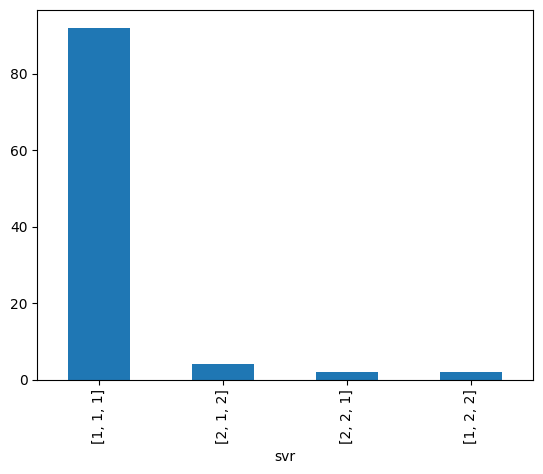

In [115]:
# gs = [ql.HGate, ql.SGate, ql.TGate, ql.CXGate]  # approx universal set
# gs = [ql.HGate, ql.CCXGate]                     # approx universal set
gs = [H, CX]

plot_svr_stat(num_of_qubits=3, min_gates=1, max_gates=3, gs=gs, samples=int(1e2),  rng=np.random.default_rng())

## SVR Test cases

In [ ]:
def test_srv(system_dims, init, target):
    vec = qi.Statevector(init, dims=system_dims)
    vec *= 1/np.sqrt(vec.trace())
    srv = schmidt_rank_vector(qi.DensityMatrix(vec)) 
    assert srv == target, f"srv: {srv}"
    print(f"passed test, svr: {srv}")
    display(vec.draw('latex', prefix='|\\psi\\rangle = '))

In [ ]:
#---------------- |0+> = |00>+|01>
system_dims = (2,2)
init = np.zeros(np.prod(system_dims), dtype=complex)
init[0] = 1
init[1] = 1
test_srv(system_dims, init, [1, 1])

#----------------Bell, |00>+|11>
system_dims = (2,2)
init = np.zeros(np.prod(system_dims), dtype=complex)
init[0] = 1
init[3] = 1
test_srv(system_dims, init, [2, 2])
  
#----------------GHZ, |000>+|111>
system_dims = (2,2,2)
init = np.zeros(np.prod(system_dims), dtype=complex)
init[0] = 1
init[7] = 1
test_srv(system_dims, init, [2,2,2])
 
#----------------Sym, |000>+|111>+|222>
system_dims = (3,3,3)
init = np.zeros(np.prod(system_dims), dtype=complex)
init[0]  = 1
init[13] = 1
init[26] = 1
test_srv(system_dims, init, [3,3,3])
      
#----------------Wikipedia example, |000>+|101>+|210>+|311>
system_dims = (4,4,4)
init = np.zeros(np.prod(system_dims), dtype=complex)
init[0]  = 1
init[17] = 1
init[36] = 1
init[53] = 1
test_srv(system_dims, init, [2, 2, 4])

passed test, svr: [1, 1]


<IPython.core.display.Latex object>

passed test, svr: [2, 2]


<IPython.core.display.Latex object>

passed test, svr: [2, 2, 2]


<IPython.core.display.Latex object>

passed test, svr: [3, 3, 3]


<IPython.core.display.Latex object>

passed test, svr: [2, 2, 4]


<IPython.core.display.Latex object>

# Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()